In [2]:
import pandas as pd
import numpy as np
from scipy import linalg, optimize
import re
import random
import math
import string
from nltk.corpus import wordnet as wn
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from nltk import word_tokenize
from scipy import optimize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix, hstack, vstack
import seaborn as sns
from textblob import TextBlob
# Graphing: 
%matplotlib inline


In [3]:
from google.colab import drive
drive.mount('/content/drive')

!ls "/content/drive/My Drive/BT4222 Data/data.csv"
# path = './data/sms.tsv'
path = '/content/drive/My Drive/BT4222 Data/data.csv'

df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/BT4222 Data/data.csv'


In [4]:
# for now, fill up by mean first
df['crime_number'].fillna(value=df['crime_number'].mean(), inplace=True)

In [5]:
# transform school to count 
def replacement(x):
  x = x.replace('"', "'")
  return x
df['school'] = df.school.apply(replacement)

def remove_fb(x):
  x = str(x)
  x = x[1:-1]
  return x
df['school'] = df.school.apply(remove_fb)

def convert_str(x):
  li = list(x.split(", '"))
  return li 
df['school'] = df.school.apply(convert_str) 

In [6]:
df['school'] = df.school.apply(len)
df['school']

0         27
1         27
2         27
3         27
4         11
          ..
132602    18
132603    18
132604    18
132605    18
132606    18
Name: school, Length: 132607, dtype: int64

In [7]:
# supermarkets to count
df['supermarkets'] = df.supermarkets.apply(remove_fb)
df['supermarkets'] = df.supermarkets.apply(convert_str) 
df['supermarkets'] = df.supermarkets.apply(len)

In [8]:
# hawker to count
df['h'] = df.hawkercentre.apply(remove_fb)
df.h
df['h'] = df.h.apply(convert_str) 
df['h'] = df.h.apply(len)

In [9]:
df = df.rename(columns={"h": "hawkers"})

In [14]:
df.drop(df.columns[0], axis = 1, inplace = True)

In [15]:
# encode property type and floor range
le = preprocessing.LabelEncoder()
df['prop'] = le.fit_transform(df['propertyType'])

le2 = preprocessing.LabelEncoder()
df['floor'] = le2.fit_transform(df['floor_range'])
df['floor']

0         0
1         0
2         0
3         0
4         1
         ..
132602    3
132603    3
132604    1
132605    1
132606    2
Name: floor, Length: 132607, dtype: int64

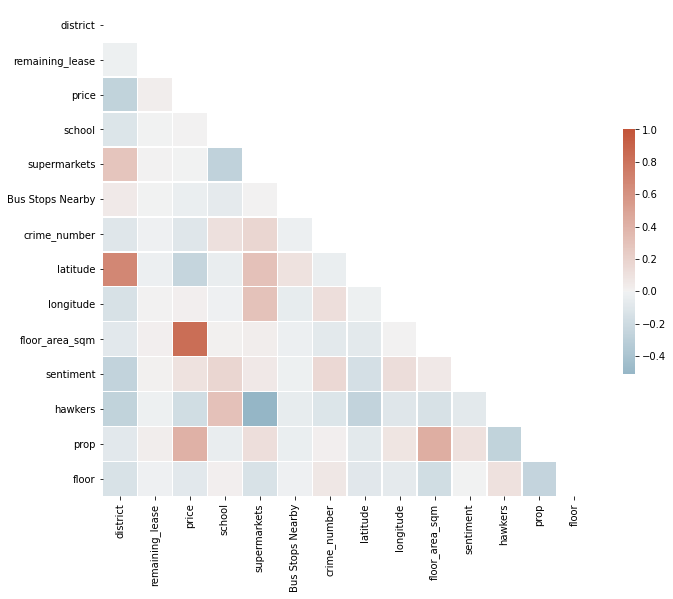

In [16]:
# correlation analysis
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [18]:
features = ['district', 'school', 'supermarkets', 'Bus Stops Nearby', 'crime_number', 'latitude', 'longitude', 'floor_area_sqm', 'hawkers', 'remaining_lease', 'prop', 'floor', 'sentiment']
X = df[features]
y = df['price']
# Scaled
y /= 1000000
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [19]:
# LightGBM RMSE: 42111
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from lightgbm import LGBMRegressor
rf = LGBMRegressor(n_estimators=300, subsample=0.9, colsample_bytree=0.2, eval_metric = 'rmse')
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(X_train)
y_pred = optimized_rf.predict(X_test)
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("r-squared: ", r2_score(y_train, y_train_pred))
print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("r-squared: ", r2_score(y_test, y_pred))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.4min finished


Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 LGBMRegressor(boosting_type='gbdt', class_weight=None,
                               colsample_bytree=0.2, eval_metric='rmse',
                               importance_type='split', learning_rate=0.1,
                               max_depth=10, min_child_samples=20,
                               min_child_weight=0.001, min_samples_leaf=2,
                               min_split_gain=0.0, n_estimators=300, n_jobs=-1,
                               num_leaves=31, objective=None, random_state=None,
                               reg_alpha=0.0, reg_lambda=0.0, silent=True,
                               subsample=0.9, subsample_for_bin=200000,
                               subsample_freq=0))],
         verbose=False)
Training Errors
Mean Squared Error:  0.22345871398099765
Mean Absolute Error:  0.1160138635522181


In [ ]:
# XGBoost RMSE: 
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn import preprocessing
from xgboost import XGBRFRegressor
rf = xgboost.XGBRegressor(n_estimators=300, subsample=0.9, colsample_bynode=0.2, n_fold = 5, eval_metric = 'rmse')
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', rf) ])
# tune the model
my_min_samples_leaf = [2, 10, 25, 50, 100]
my_max_depth = [7, 8, 9, 10, 11, 12]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_rf = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__min_samples_leaf = my_min_samples_leaf, model__max_depth = my_max_depth)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_rf.fit(X_train, y_train)
# show the best model estimators
print(optimized_rf.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_train_pred = optimized_rf.predict(X_train)
y_pred = optimized_rf.predict(X_test)
print('Training Errors')
print("Mean Squared Error: ", mean_squared_error(y_train, y_train_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_train, y_train_pred))
print("r-squared: ", r2_score(y_train, y_train_pred))
print('Test Errors')
print("Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("r-squared: ", r2_score(y_test, y_pred))  

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  9.5min
